# Districts

District should be derived using a car-based street network and for an area that is larger than the case study area (see below, e.g. for the city centre of London one should use Greater London)

In [4]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
pd.options.display.float_format = '{:20.2f}'.format
pd.options.mode.chained_assignment = None

import cityImage as ci

## Acquiring the Street Network

In [5]:
city_name = 'Tripoli, Lebanon'
epsg = 22780
crs = 'EPSG:'+str(epsg)

### Download from OSM the **drive** network

Choose between the following methods:
* `OSMplace`, provide an OSM place name (e.g. City).
* `polygon`, provide an WGS polygon of the case-study area.
* `distance_from_address`, provide a precise address and define parameter `distance` (which is otherwise not necessary)

In [6]:
place = 'Tripoli, Lebanon'
download_method = 'distance_from_address'
distance = 3000

nodes_graph, edges_graph = ci.get_network_fromOSM(place, download_method, 'drive', epsg, distance = distance)
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_islands = True,
                            self_loops = True, same_vertexes_edges = True)

# Creating and saving the dual geodataframes
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)

### Alternatively, Load from local path 
Only run when the network has already been processed and cleaned.

In [ ]:
input_path = 'output/'+city_name

nodes_graph = gpd.read_file(input_path+'_nodes.shp')
edges_graph = gpd.read_file(input_path+'_edges.shp')
nodesDual_graph = gpd.read_file(input_path+'_nodesDual.shp')
edgesDual_graph = gpd.read_file(input_path+'_edgesDual.shp')
    
nodes_graph.index, edges_graph.index, nodesDual_graph.index = nodes_graph.nodeID, edges_graph.edgeID, nodesDual_graph.edgeID
nodes_graph.index.name, edges_graph.index.name, nodesDual_graph.index.name = None, None, None

**Visualisation**

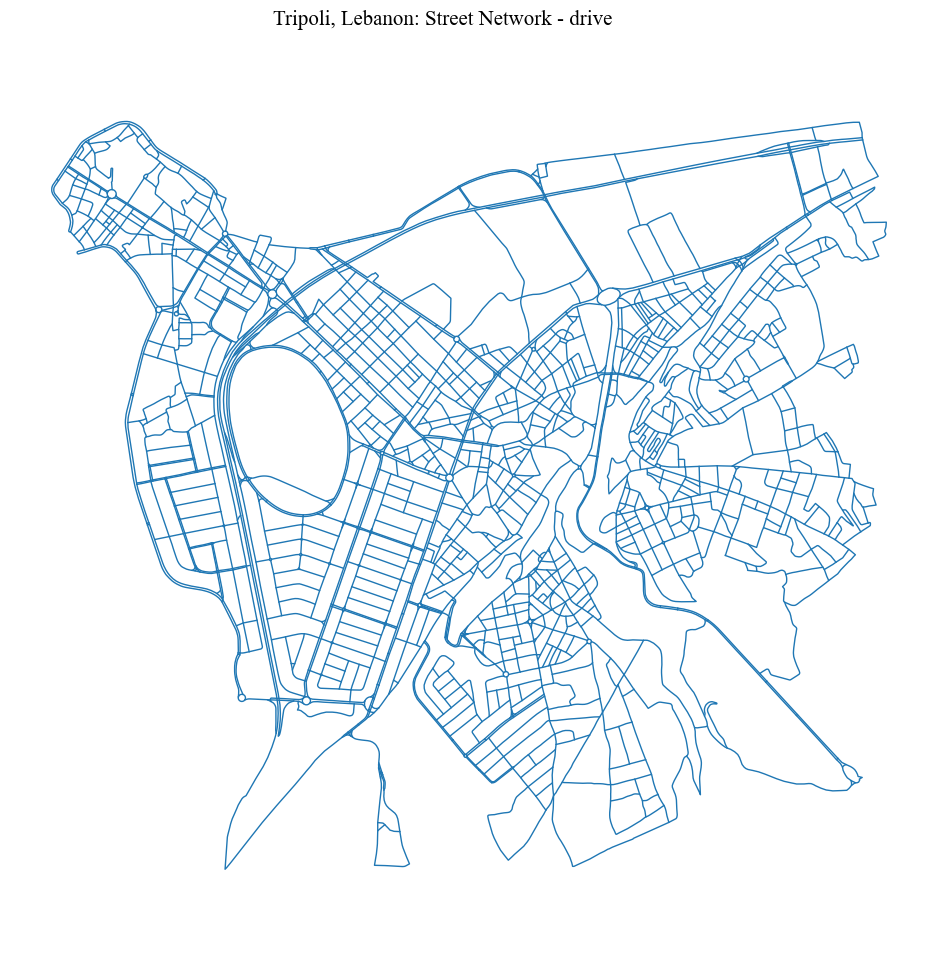

In [7]:
fig = ci.plot_gdf(edges_graph, black_background = False, figsize = (10,10), title = city_name+': Street Network - drive')

## District identification

In [8]:
# creating the dual_graph
dual_graph = ci.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

Different weights can be used to extract the partitions. `None` indicates that no weights will be used 
(only topological relationships will matter). The function returns a GeoDataFrame with partitions assigned to edges,
with column named as `p_name_weight` (e.g. `p_length`).

In [9]:
weights = ['length', 'rad', None]
districts = edges_graph.copy()
for weight in weights:
    districts = ci.identify_regions(dual_graph, districts, weight = weight)

**Visualisation**

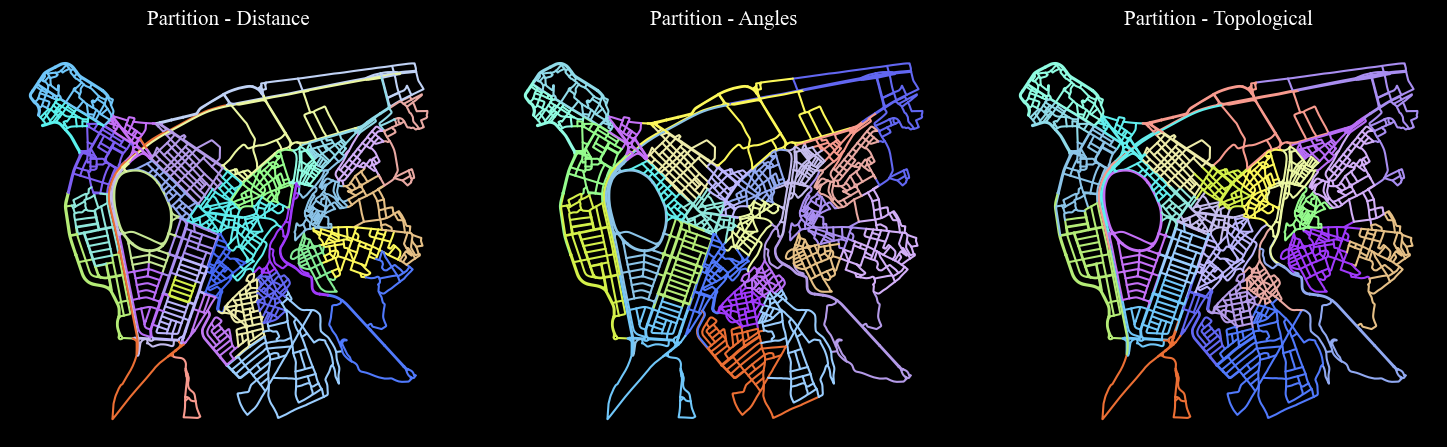

In [10]:
columns = ['p_length','p_rad', 'p_topo']
titles = ['Partition - Distance', 'Partition - Angles', 'Partition - Topological']

nlabels = max([len(districts[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_grid_gdf_columns(districts, columns = columns, titles = titles, geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 10), ncols = 3, nrows = 1)

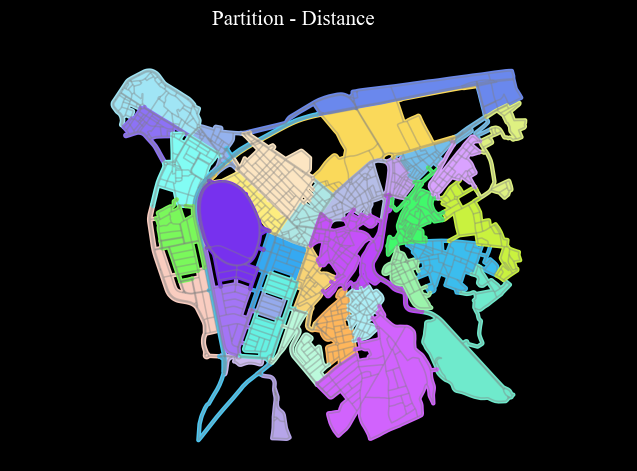

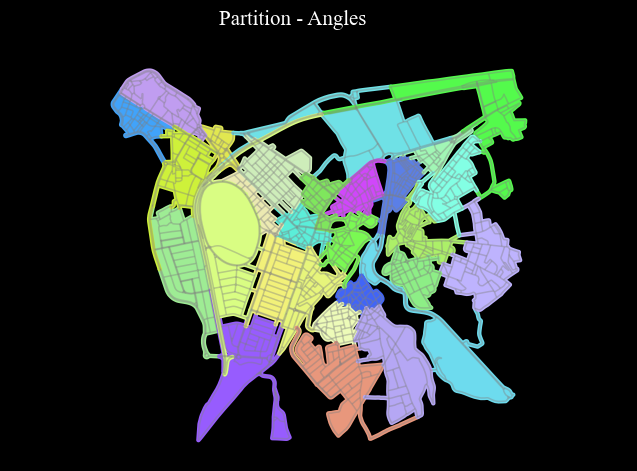

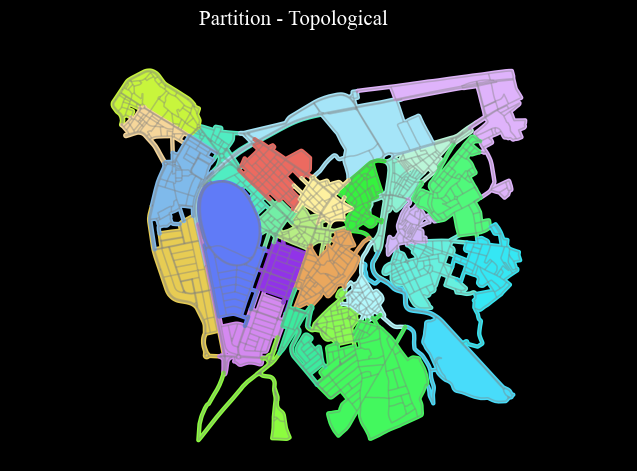

In [11]:
for n, column in enumerate(columns):
    cmap = ci.rand_cmap(nlabels = len(districts[column].unique()), type_color='bright')
    partitions = ci.polygonise_partitions(districts, column, convex_hull = False)
    ci.plot_gdf(partitions, column = column, cmap = cmap, title =  titles[n], black_background = True,  figsize = (7, 5), 
               base_map_gdf = districts, base_map_color = 'grey', base_map_zorder = 1)

**Exporting**

In [30]:
# provide path
output_path = '../output/'+city_name
ci.remove_lists_columns(districts).to_file(output_path+"_edges_districts.gpkg",  driver="GPKG")

## Assigning regions to the Network of the Case-study area (From OSM relation or polygon)

In [35]:
# study_area_polygon = ox.geocode_to_gdf("Tripoli, Lebanon").to_crs(crs).iloc[0].geometry
study_area_polygon = gpd.read_file("../data/Tripoli_boundary.gpkg",  driver="GPKG").iloc[0].geometry.buffer(50)
el_mina_tripoli_districts = districts[districts.geometry.within(study_area_polygon)]

**Visualisation**

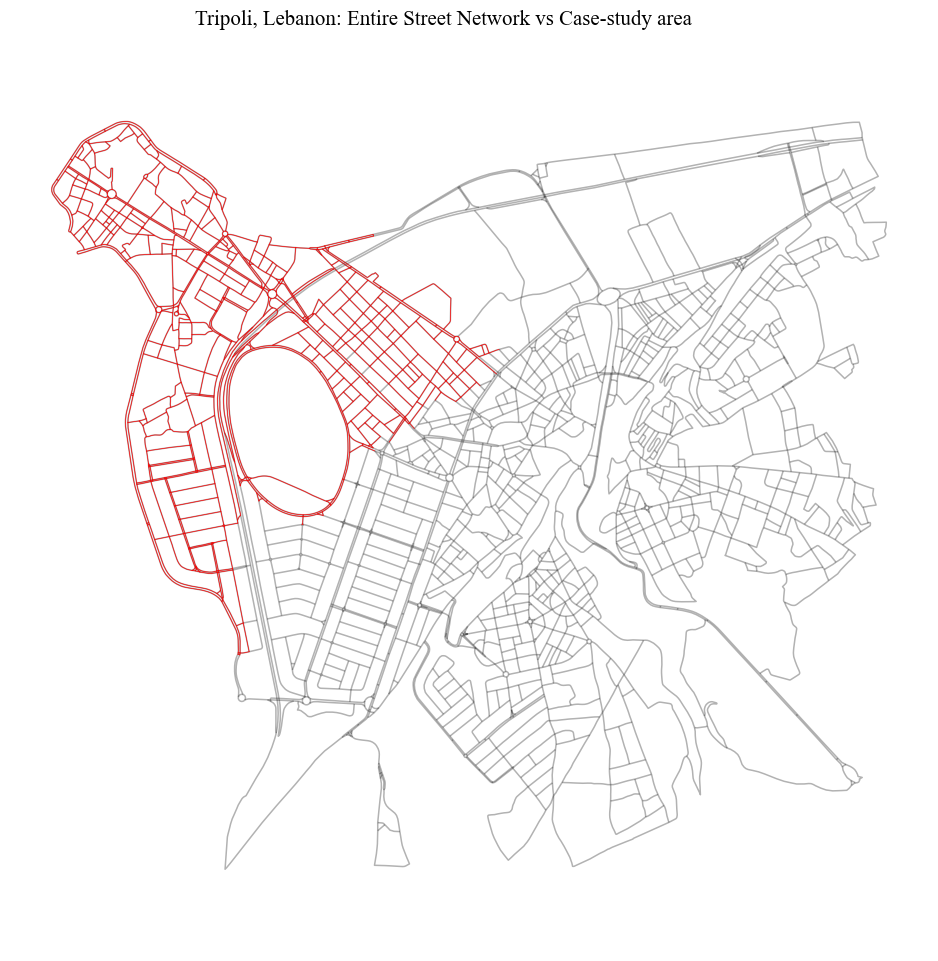

In [36]:
fig = ci.plot_gdf(el_mina_tripoli_districts, scheme = None,  black_background = False, figsize = (10,10), title = 
              city_name+': Entire Street Network vs Case-study area', color = 'red', geometry_size = 0.5,
             base_map_gdf = districts, base_map_color = 'black', base_map_alpha = 0.3)

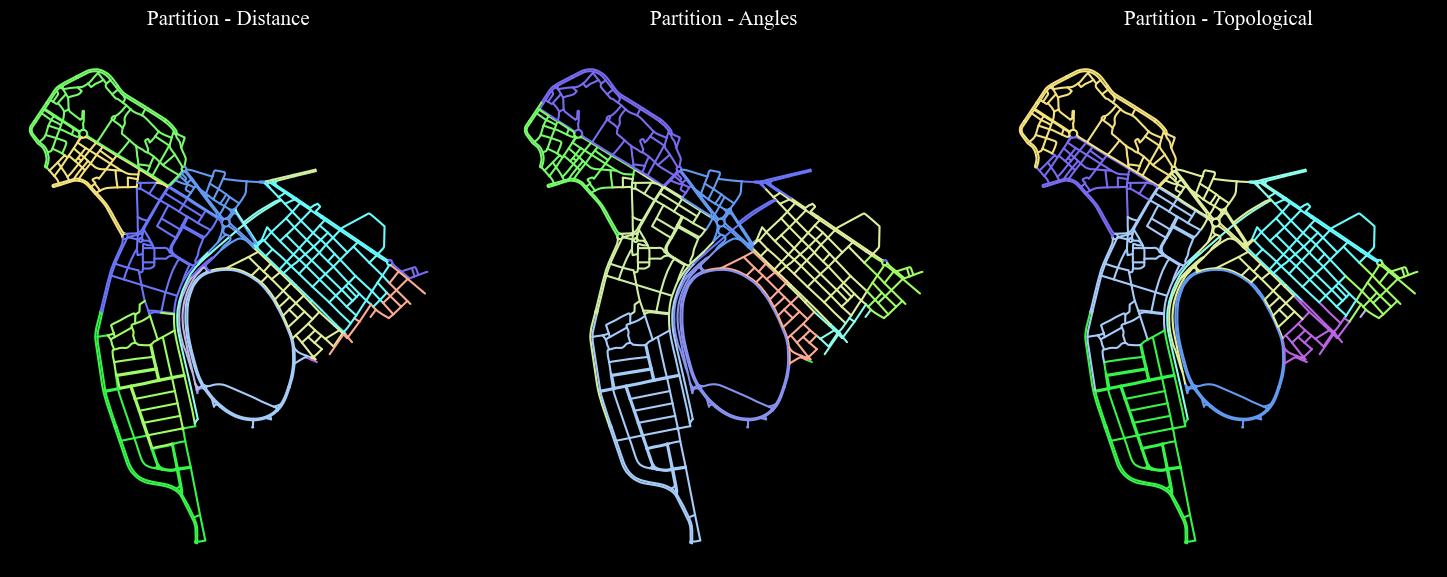

In [38]:
columns = ['p_length','p_rad', 'p_topo']
titles = ['Partition - Distance', 'Partition - Angles', 'Partition - Topological']

nlabels = max([len(el_mina_tripoli_districts[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_grid_gdf_columns(el_mina_tripoli_districts, columns = columns, titles = titles, geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 10), ncols = 3, nrows = 1)

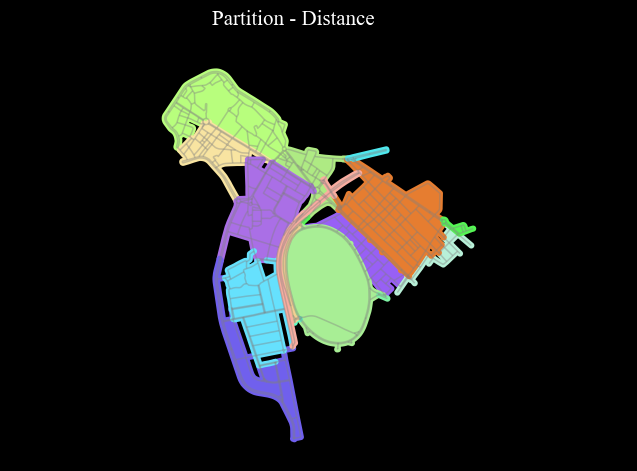

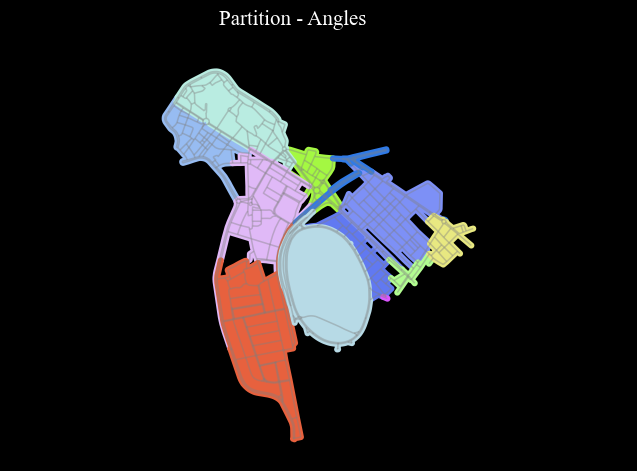

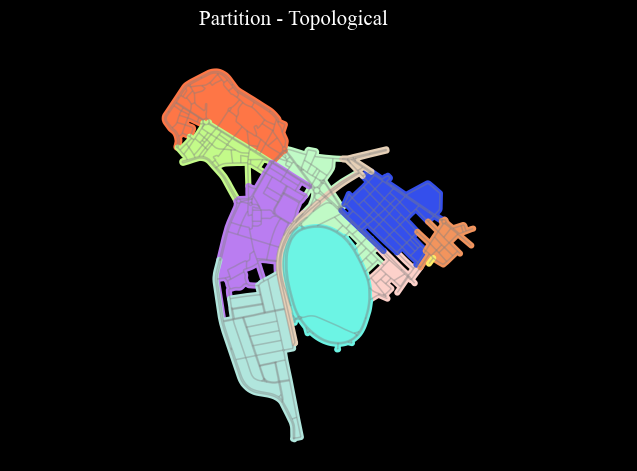

In [39]:
for n, column in enumerate(columns):
    cmap = ci.rand_cmap(nlabels = len(el_mina_tripoli_districts[column].unique()), type_color='bright')
    partitions = ci.polygonise_partitions(el_mina_tripoli_districts, column, convex_hull = False)
    ci.plot_gdf(partitions, column = column, cmap = cmap, title =  titles[n], black_background = True,  figsize = (7, 5), 
               base_map_gdf = el_mina_tripoli_districts, base_map_color = 'grey', base_map_zorder = 1)

**Exporting**

In [40]:
el_mina_tripoli_districts.to_file("../output/el_mina_tripoli_districts.gpkg", driver="GPKG")